In [ ]:
!unzip /content/v7.zip

unzip:  cannot find or open /content/v7.zip, /content/v7.zip.zip or /content/v7.zip.ZIP.


In [1]:
# !pip install tflite-support

import os
import numpy as np
import tensorflow as tf
from google.colab import files
print(tf.__version__)

2.12.0


In [2]:
# Frozen Model export reference
# https://github.com/PINTO0309/PINTO_model_zoo/tree/master/01_deeplabv3/04_mobilenetv2_dm10/02_coco_voc_trainval

In [38]:
modelName = "mnv3Large_b32_withFinetune_sslr1e-15_blr1e-12_adam_alr1e-12_dos8_os32_mms_minsf-0-75_maxsf-1-75_sfss_0-05_s11685_loss0-xx"

# Convert

## Download Model or show path

In [39]:
#@title Show uploaded frozen model path
MODEL_FILE = "/content/" + modelName + ".pb" #@param {type:"string"}

In [40]:
#@title Download frozen model (run if default model is needed)
# https://github.com/tensorflow/tensorflow/issues/23747#issuecomment-562964513
# https://github.com/PINTO0309/PINTO_model_zoo/blob/master/01_deeplabv3/04_mobilenetv2_dm10/02_coco_voc_trainval/download.sh
#!gdown --id 1NNxkATTAkLtn_QBZqTSLHuxnlhYBnaXY
#!tar -zxvf resources.tar.gz --wildcards --no-anchored 'frozen_inference_graph_*.pb'
#MODEL_FILE = "frozen_inference_graph_257.pb" #@param {type:"string"}

## TFLite Conversion



In [41]:
# Load the TensorFlow model
converter = tf.compat.v1.lite.TFLiteConverter.from_frozen_graph(
    graph_def_file = MODEL_FILE, 
    input_arrays = ['sub_2'], # For the Xception model it needs to be `sub_7`, for MobileNet it would be `sub_2`
    output_arrays = ['ResizeBilinear_2'],
    input_shapes={'sub_2':[1,257,257,3]}
)
# converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir=MODEL_FILE)

# will add quantization and optimization if needed according to this documents
# https://www.tensorflow.org/lite/performance/post_training_quantization#dynamic_range_quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert to TFLite Model
tflite_model = converter.convert()

tflite_path = modelName + ".tflite" #@param {type:"string"}
tflite_model_size = open(tflite_path, 'wb').write(tflite_model)
tf_model_size = os.path.getsize(MODEL_FILE)
print('TensorFlow Model is  {} bytes'.format(tf_model_size))
print('TFLite Model is      {} bytes'.format(tflite_model_size))
print('Post training quantization saves {} bytes'.format(tf_model_size-tflite_model_size))

files.download(tflite_path)
print('tflite model Download complete')

TensorFlow Model is  6300629 bytes
TFLite Model is      1748096 bytes
Post training quantization saves 4552533 bytes


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tflite model Download complete


## Inference with deeplab tflite model

In [42]:
#@title 1. Provide a URL to your image to download
#IMAGE_URL = 'https://www.google.com/url?sa=i&url=https%3A%2F%2Fstock.adobe.com%2Fsearch%3Fk%3Dface&psig=AOvVaw2iEk9DqIT2_bOvAh_Vj6kF&ust=1668831551336000&source=images&cd=vfe&ved=0CA8QjRxqFwoTCLiWwejwtvsCFQAAAAAdAAAAABAE' #@param {type:"string"}
#!wget -O image.jpg {IMAGE_URL}

#from PIL import Image
#image = Image.open('/content/image.jpg')
#image

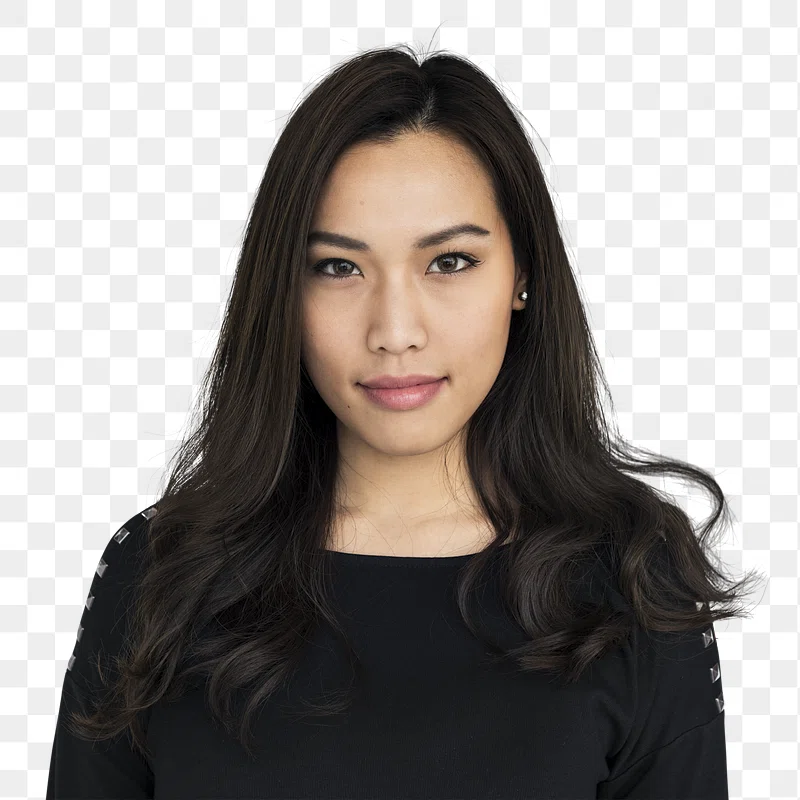

In [43]:
from PIL import Image
image = Image.open('/content/download.png')
image

(257, 257)
(800, 800) (800, 800)


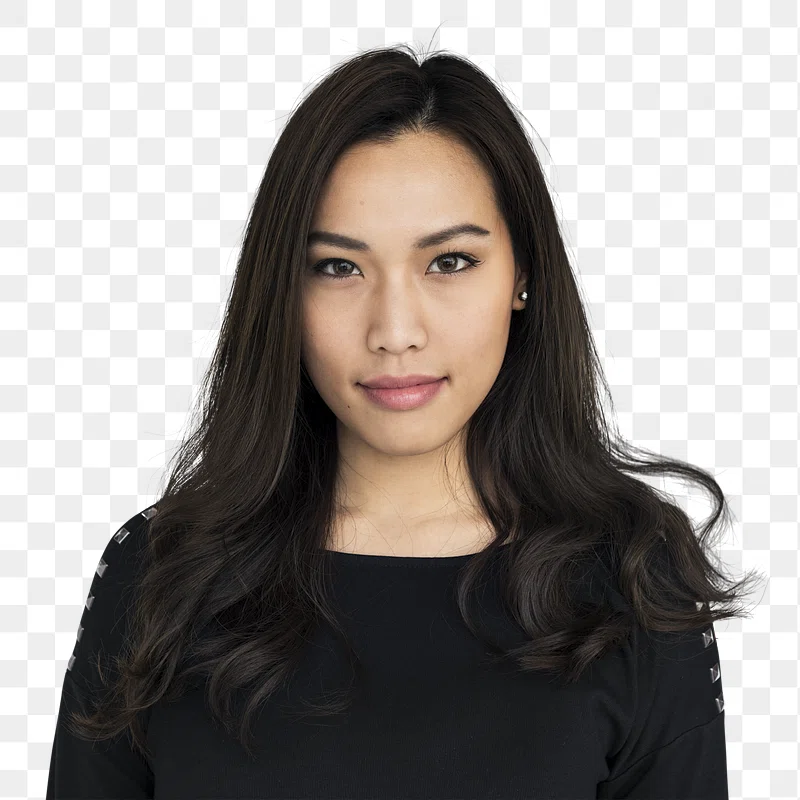

In [44]:
#@title 2. Initialize python interpreter, Resize the Image and preprocess for model input

# Load the model.
interpreter = tf.lite.Interpreter(model_path=tflite_path)

# Set model input.
input_details = interpreter.get_input_details()
interpreter.allocate_tensors()

# Get image size - converting from BHWC to WH # ([1,1025,2049,19]: Shape of ResizeBilinear_2 op)
input_size = input_details[0]['shape'][2], input_details[0]['shape'][1]
print(input_size)


## Crop the Image 
from PIL import ImageOps

old_size = image.size  # old_size is in (width, height) format
desired_ratio = input_size[0] / input_size[1]
old_ratio = old_size[0] / old_size[1]

if old_ratio < desired_ratio: # '<': cropping, '>': padding
    new_size = (old_size[0], int(old_size[0] / desired_ratio))
else:
    new_size = (int(old_size[1] * desired_ratio), old_size[1])

print(new_size, old_size)

# Cropping the original image to the desired aspect ratio
delta_w = new_size[0] - old_size[0]
delta_h = new_size[1] - old_size[1]
padding = (delta_w//2, delta_h//2, delta_w-(delta_w//2), delta_h-(delta_h//2))
cropped_image = ImageOps.expand(image, padding)

## Preprocess for model input
# Resize the cropped image to the desired model size
resized_image = cropped_image.convert('RGB').resize(input_size, Image.BILINEAR)


# Convert to a NumPy array, add a batch dimension, and normalize the image.
image_for_prediction = np.asarray(resized_image).astype(np.float32)
image_for_prediction = np.expand_dims(image_for_prediction, 0)
image_for_prediction = image_for_prediction / 127.5 - 1
cropped_image


In [45]:
#@title 3. Run Inference on model
# Load the model.
# interpreter = tf.lite.Interpreter(model_path=tflite_path)

# # Invoke the interpreter to run inference.
# interpreter.allocate_tensors()
interpreter.set_tensor(input_details[0]['index'], image_for_prediction)
interpreter.invoke()

# Retrieve the raw output map.
raw_prediction = interpreter.tensor(
    interpreter.get_output_details()[0]['index'])()

# Post-processing: convert raw output to segmentation output
## Method 1: argmax before resize - this is used in some frozen graph
# seg_map = np.squeeze(np.argmax(raw_prediction, axis=3)).astype(np.int8)
# seg_map = np.asarray(Image.fromarray(seg_map).resize(image.size, resample=Image.NEAREST))
## Method 2: resize then argmax - this is used in some other frozen graph and produce smoother output
width, height = cropped_image.size
seg_map = tf.argmax(tf.image.resize(raw_prediction, (height, width)), axis=3)
seg_map = tf.squeeze(seg_map).numpy().astype(np.int8)

# Visualize

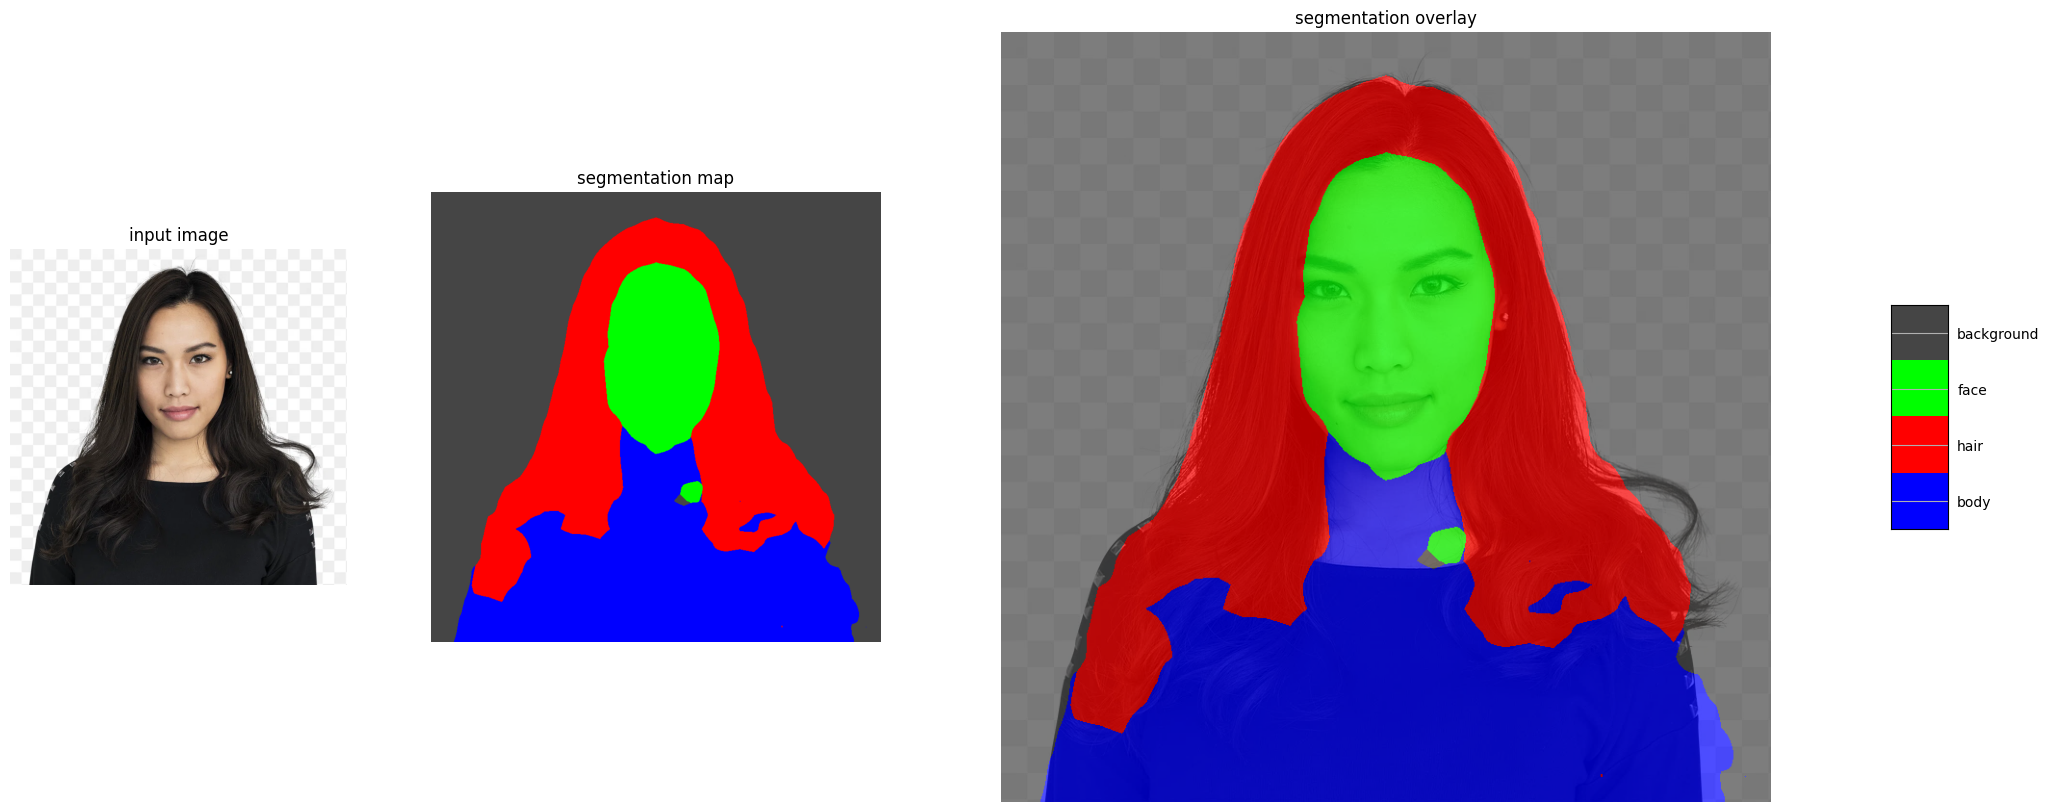

In [46]:
#@title 4. Visualize inference result
from matplotlib import gridspec
from matplotlib import pyplot as plt

def create_cityscapes_label_colormap():
  """Creates a label colormap used in CITYSCAPES segmentation benchmark.
  Returns:
    A colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=np.uint8)
  colormap[0] = [69, 69, 69]
  colormap[1] = [0, 255, 0]
  colormap[2] = [255, 0, 0]
  colormap[3] = [0, 0, 255]

  return colormap


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_cityscapes_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]


def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(25, 10))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 8, 15, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()


# LABEL_NAMES = np.asarray([
#       'background'
#       'road',
#       'sidewalk',
#       'building',
#       'wall',
#       'fence',
#       'pole',
#       'traffic light',
#       'traffic sign',
#       'vegetation',
#       'terrain',
#       'sky',
#       'person',
#       'rider',
#       'car',
#       'truck',
#       'bus',
#       'train',
#       'motorcycle',
#       'bicycle',
# ])

#Labels for deeplabv3_mnv2_dm10
LABEL_NAMES = np.asarray([
      "background", "face", "hair", "body"
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)
vis_segmentation(cropped_image, seg_map)

In [ ]:
seg_map.shape